# Anomaly Detection

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.cluster import KMeans

import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Exercise 1 -  Multivariate Gaussian distribution
In the lecture we discussed anomaly detection using the univariate Gaussian distribution. There is a data set on ILIAS containing credit card transactions made available by a European bank in September 2013 on [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). Not surprisingly, the data set is anonymized, i.e. a PCA transformation was executed on all features (each feature therefore is a linear combination of the original but unknown features). The only exceptions are amount and time (milliseconds since first transaction). Finally, there is a class feature to indicate whether the transaction is fraudulent (value: 1) or genuine (value: 0). In this exercise we will guide you through the implementation of fraud detetion using anomaly detection with the multivariate Gaussian distribution. 

### Data Quality Assessment

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape

(284807, 31)

> Check for null values

In [5]:
df.isnull().sum().sum()

0

#### Split fraudulent data from genuine data
We start by separating the genuine data from the fraudulent data

In [6]:
genuine = df[df["Class"] == 0]
anomalies = df[df["Class"] == 1]
print("Genuine Transactions:", genuine.shape[0])
print("Anomalous Transaction:", anomalies.shape[0])

Genuine Transactions: 284315
Anomalous Transaction: 492


#### Amount feature
Fortunately, that *Amount* feature has not been anonymized with the PCA transformation. So let's take a look at the *Amount* feature and see if we can find a pattern.

Mean 88.29102242231328
Median 22.0


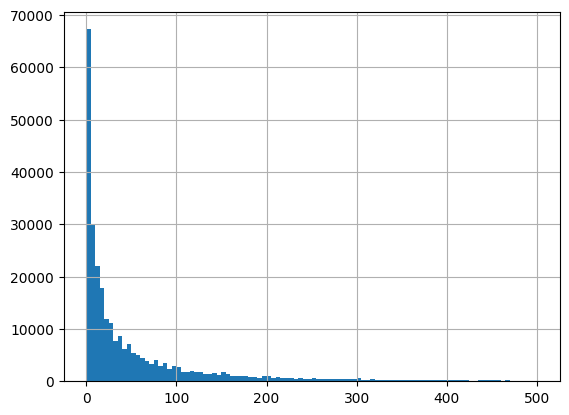

In [7]:
genuine.Amount.loc[genuine.Amount < 500].hist(bins=100)
print("Mean", genuine.Amount.mean())
print("Median", genuine.Amount.median())

Mean 122.21132113821139
Median 9.25


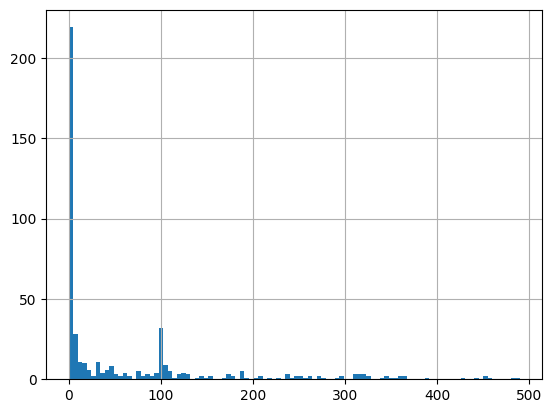

In [8]:
anomalies.Amount.loc[anomalies.Amount < 500].hist(bins=100)
print("Mean", anomalies.Amount.mean())
print("Median", anomalies.Amount.median())

* Interestingly the median is lower but the mean is higher for the fraudulent transactions. This suggests there are some high value oriented criminals and some that focus on withdrawals "below the radar" to avoid detection

### Feature Engineering

#### Distribution of the features
We want to model our anomaly detection by fitting a multivariate gaussian distribution. Therefore it makes sense to plot the distribution of our features. We plot the genuine and the fraudulent transactions separately.

  0%|          | 0/30 [00:00<?, ?it/s]

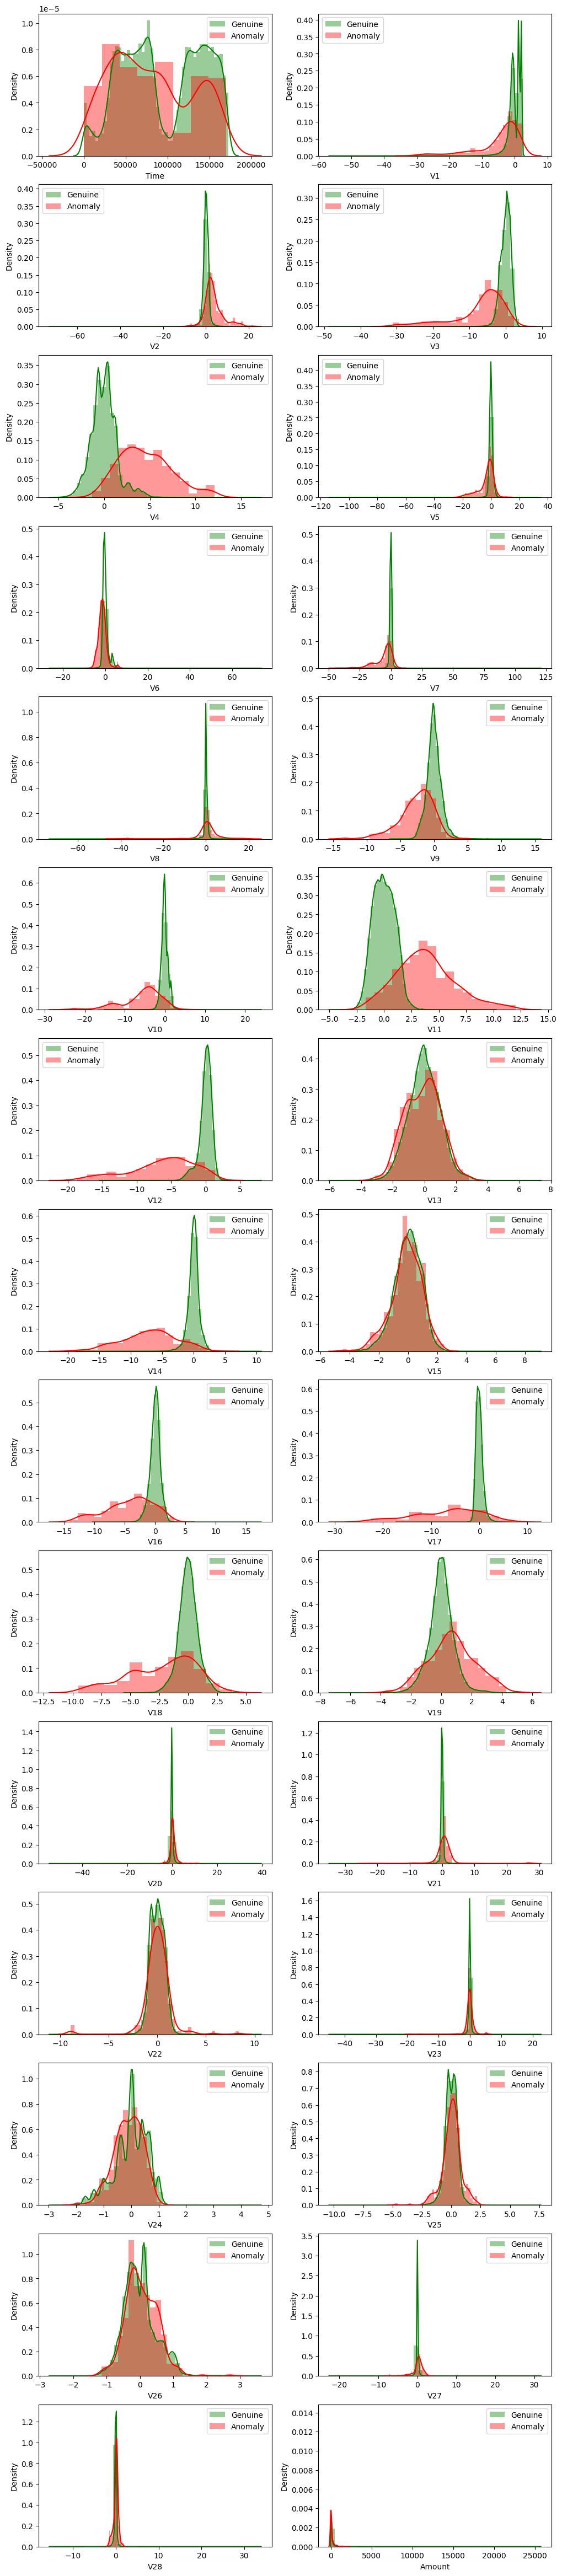

In [9]:
feature_cols = genuine.drop(columns=["Class"]).columns
plt.figure(figsize=(12, len(feature_cols)*4))
gs = gridspec.GridSpec(len(feature_cols), 2)

for i, col in enumerate(tqdm(feature_cols)):
    ax = plt.subplot(gs[i])
    sns.distplot(genuine[col], color='g',label='Genuine')
    sns.distplot(anomalies[col], color='r',label='Anomaly')
    ax.legend()
plt.show()

> Based on the plots we made, drop the features that might not be useful.

In [10]:
features_to_drop = ['Time', 'V8', 'V13', 'V15', 'V20', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

* We can see that the distribution of the fraudulent transaction (class=1) is matching with the genuine transactions (class=0) for the following features:
 * *V8*, *V13*, *V15*, *V20*, *V22*, *V23*, *V24*, *V25*, *V26*, *V27*, *V28*
 * Therefore they might not be useful in finding fradulent transactions. 
* The variable *Time* is also not a useful variable since it contains the seconds elapsed between the transaction for that record and the first transaction in the dataset. The data is in increasing order, which can lead to a singular covariance matrix. Also it is not normally distributed.

Let's drop these features in our splitted dataset

In [11]:
genuine = genuine.drop(features_to_drop, axis=1)
anomalies = anomalies.drop(features_to_drop, axis=1)

#### Split the data
We split the targets from the features

In [12]:
genuine_X = genuine.drop(columns=["Class"]).values
genuine_y = genuine.Class.values

anomalies_X = anomalies.drop(columns=["Class"]).values
anomalies_y = anomalies.Class.values

Now we use 60% of the *genuine* data as the training set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(genuine_X, genuine_y, test_size=0.4, random_state=42)

And add the anomalies to the test set

In [14]:
# Add anomalies to the test set
X_test = np.concatenate([X_test, anomalies_X])
y_test = np.concatenate([y_test, anomalies_y])

print(X_test.shape)
print(y_test.shape)
print("Number of anomalies:", y_test.sum())

(114218, 18)
(114218,)
Number of anomalies: 492


*(Note that because we further split the data we don't have to shuffle it)*

Now we can further split the test data into a test set and a validation set.

In [15]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(X_test.shape)
print(y_test.shape)
print("Number of anomalies y_test:", y_test.sum())
print(X_val.shape)
print(y_val.shape)
print("Number of anomalies y_val:", y_val.sum())

(57109, 18)
(57109,)
Number of anomalies y_test: 231
(57109, 18)
(57109,)
Number of anomalies y_val: 261


#### Data Normalization
Now that we have splitted our data, we can normalize it by applying z-normalization.

> Normalize the data

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

### Baseline model
To get an idea on how good our model performs, let's implement a dummy predictor. Our dummy model should mark each transaction as genuine

> Implement the dummy predictor

In [38]:
def dummy_predict(X):
    return np.zeros(X.shape[0])

> Now predict on the test set and calculate the accuracy by using the Scikit-Learn function [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

In [39]:
y_pred = dummy_predict(X_test)
accuracy_score(y_pred, y_test)

0.9959551033987638

Wow, such a high accuracy! It seems like our work is done and we can spend the rest of our day drinking coffee!

Okay, let's be honest there must be a mistake. 

> Let's check how many fraudulent and genuine data we have.

In [40]:
print(df.Class.value_counts())
print("Percentage of fraudulent data:", 100*df.Class.value_counts()[1] /len(df))

0    284315
1       492
Name: Class, dtype: int64
Percentage of fraudulent data: 0.1727485630620034


It looks like our dataset is highly imbalanced! We could create a balanced test set and then calculate the accuracy. But there must be another way... Let's plot the confusion matrix first.

In [41]:
def plot_confusion_matrix(cm):
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Genuine', 'Fraud'],
                yticklabels=['Genuine', 'Fraud'],
                annot=True,ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

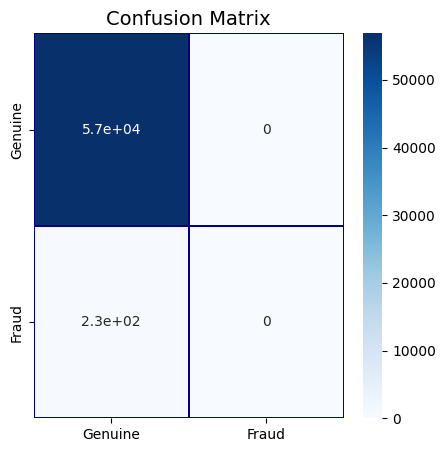

In [42]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

We can see that we have a lot of *True Positives* and only few *True Negatives*. This is due to the class imbalance.

### Precision, Recall and F1 Score
For a skewed data set, we often use other metrics like [Precision](https://en.wikipedia.org/wiki/Precision_and_recall), [Recall](https://en.wikipedia.org/wiki/Precision_and_recall) or the harmonic mean of both, called [F1 Score](https://en.wikipedia.org/wiki/F1_score). Scikit-Learn provides the function [precision_recall_fscore_support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) which calculates all these metrics at once.

In [43]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
print("Precision:", precision)
print("Recall", recall)
print("F1", f1)

Precision: 0.0
Recall 0.0
F1 0.0


c:\Users\David\Desktop\HSLU\sem4\adml\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now it's clear that our dummy anomaly detection model performs really bad! So let's stick to those metrics.

### Fit the multivariate gaussian distribution
Now that we have splitted our data set into a training, test and cross validation set, we can train our anomaly detection model.

> Complete the `fit` function which calculate the *mean* and the *covariance* matrix from the training set and then fits a multivariate gaussian distribution. Use the [multivariate_normal](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html) function from SciPy.

In [44]:
def fit(X):
    mu = np.mean(X, axis=0)
    cov = np.cov(X.T)
    gauss = multivariate_normal(mean=mu, cov=cov)
    return gauss


In [45]:
gauss = fit(X_train)

### Predict anomalies
Let's use our fitted gaussian distribution to predict anomalies. 

> Use the `pdf` method of the gauss model to calculate the densities. Then mark all elements which are below the threshold `epsilon` as an anomaly. We use the value 10<sup>-20</sup> as the threshold.

In [46]:
def predict(X, gauss, eps):
    densities = gauss.pdf(X)
    y_pred = densities < eps
    return y_pred

In [47]:
eps = 1e-20
y_pred = predict(X_test, gauss, eps)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
print("Precision:", precision)
print("Recall", recall)
print("F1", f1)

Precision: 0.12998040496407576
Recall 0.8614718614718615
F1 0.22587968217934162


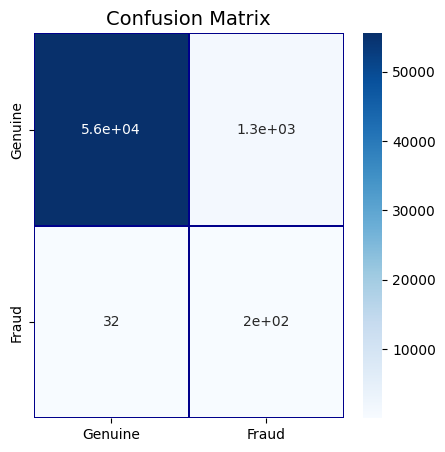

In [48]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

* We have a relatively high recall value, which means that our model does detect most of the anomalies. 
* The low precision value  however indicates that we have a lot of *False Positives*. *False Positives* are the genuine transaction which were classified as frauds. 
* This might be a good model if for example the model is only used to determine if the user has to enter an extra verification code. However if those cards would be blocked, this would be really bad.

### Hyperparameter tuning
Our threshold `eps` is the hyperparameter we would like to tune. 

But first we take a look at our densities

In [49]:
densities = gauss.pdf(X_val)
print("Min density:", densities.min())
print("Max density:", densities.max())

Min density: 0.0
Max density: 8.41619337890157e-08


The values of our densities seem to be rather small! Luckily when we are dealing with probabilities we can always apply a logarithmic transformation as it is a strictly monotonic function. Scipy already privdes an implementation `logpdf`. 
Let's check the values of our log transformed densities.

In [50]:
densities = gauss.logpdf(X_val)
print("Min density:", densities.min())
print("Max density:", densities.max())

Min density: -12344.17642188291
Max density: -16.29052311068991


These values look much better. However in order to reuse our existing code we need to redefine our `predict` function. 

> Reimplement the `predict` function but this time use `logpdf` instead of the `pdf` function.

In [51]:
def predict(X, gauss, eps):
    densities = gauss.logpdf(X)
    y_pred = densities < eps
    return y_pred

#### Fit our threshold by sorting
We can try to find the optimal threshold by sorting our densities and then picking the density with the index of the number of anomalies on our validation set.

In [55]:
expected_anomalies = y_val.sum()
sorted_densities = np.sort(gauss.logpdf(X_val))
best_eps = (sorted_densities[expected_anomalies] + 
            0.5 * (sorted_densities[expected_anomalies + 1] - 
                   sorted_densities[expected_anomalies]))


y_pred = predict(X_val, gauss, best_eps)
f1 = f1_score(y_val, y_pred, average="binary")
print("Best epsilon {} with f1 score {}".format(best_eps, f1))

Best epsilon -281.55123090658935 with f1 score 0.7227533460803058


Wow this worked out very well on our validation set! Let's check if we can still improve our result by applying a grid search approach.

#### Grid Search Approach

We calculate the densities for each anomaly and assume that the maximum epsilon is equal to the maximum density. We take $-500$ as our minimum `epsilon` for now.

In [56]:
densities.min()

-12344.17642188291

In [57]:
X_anomalies =  anomalies.drop(columns=["Class"]).values
densities = gauss.logpdf(X_val)

max_eps = densities.max()
print("Maximum epsilon:", max_eps)

min_eps = -500
print("Minimum epsilon:", min_eps)

Maximum epsilon: -16.29052311068991
Minimum epsilon: -500


This means the optimal value of `epsilon` lies between -500 and -16. Let's try to find it by using a grid search approach.
> Loop through the list of epsilons and calculate for each epsilon the *precision*, *recall* and *f1* score. 

In [58]:
f1_scores = []
recall_scores = []
precision_scores = []

epsilons = np.linspace(min_eps, max_eps, num=1000)
densities = gauss.logpdf(X_val)
for eps in tqdm(epsilons):
    y_pred = densities < eps
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average="binary")
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
best_eps_gridsearch = epsilons[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print("Best epsilon {} with f1 score {}".format(best_eps_gridsearch, best_f1))

  0%|          | 0/1000 [00:00<?, ?it/s]

Best epsilon -303.90156342325264 with f1 score 0.7325581395348838


##### Visualization
Let's visualize the *F1*, *Precision* and *Recall* curves

(-16.29052311068991, -500.0)

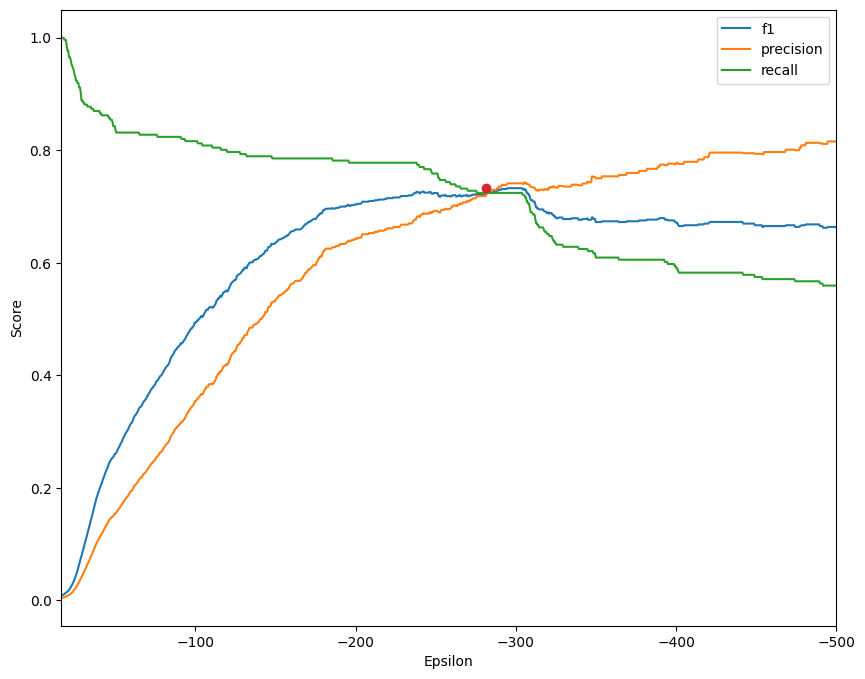

In [59]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(epsilons, f1_scores, label="f1")
ax.plot(epsilons, precision_scores, label="precision")
ax.plot(epsilons, recall_scores, label="recall")
ax.plot(best_eps, best_f1, marker="o")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Score")
ax.legend()
ax.set_xlim(max_eps, min_eps)

### Evaluate the model on the test set

As we have selected an epsilon, we can check how good our model performs on the test set.

In [60]:
y_pred = predict(X_test, gauss, best_eps)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
print("Precision:", precision)
print("Recall", recall)
print("F1", f1)

Precision: 0.7086956521739131
Recall 0.7056277056277056
F1 0.7071583514099784


We plot the confusion matrix again

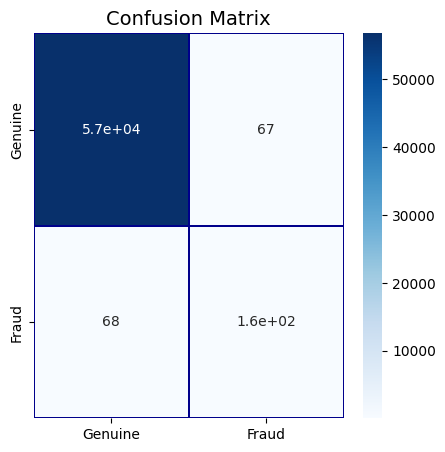

In [61]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)